<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/AdjointSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adjoint Sampling Demo

This notebook implements the method described in https://arxiv.org/abs/2504.11713

For simplicity we are going to consider the following base process:
$$ d X_t = d B_t $$
i.e. $\sigma(t)= 1$ and not drift term. With this particular choice, $p_1^{base} = \mathcal{N}(0, I)$ and $p_t^{base}(X_t | X_1) = \mathcal{N}(t X_1, t*(1-t) I)$ (see appendix B for more details).

We will aim to learn a control function $u_\theta(X_t, t)$ such that the following SDE will sample from the desired density:

$$d X_t = u_\theta(X_t, t) + dB_t $$


Ok, let's do it!

### Installing dependencies and imports

In [1]:
!pip install --quiet diffrax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 7.8 MB/s eta 0:00:00


In [2]:
%pylab inline
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


## Step I: Create a target distribution to sample

Here we will define a target distribution of flexible difficulty as a gaussian mixture model.

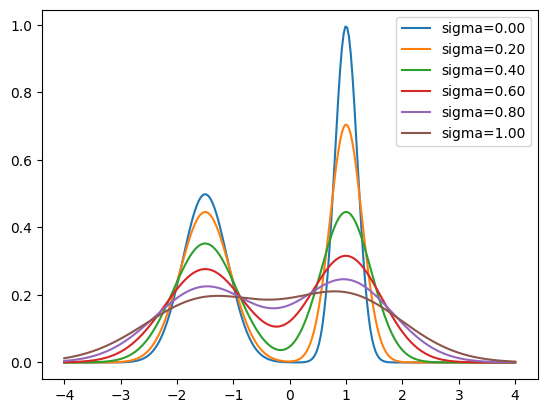

In [3]:
def make_dist(sigma=0.):
  """
  Returns a mixture of Gaussians, convolved with a Gaussian of specified sigma
  """
  gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]),
    components_distribution=tfd.Normal(
      loc=[-1.5, 1.],
      scale=[jnp.sqrt(0.4**2+sigma**2),
             jnp.sqrt(0.2**2+sigma**2)]))
  return gm

# Let's visualize the possible target distributions
x = jnp.linspace(-4, 4, 256)
for i in [0.0, 0.2, 0.4, 0.6, 0.8, 1.]:
  plot(x, make_dist(sigma=i).prob(x),label='sigma=%0.2f'%i);
legend();

For small sigmas, the sampling problem becomes more difficult, as the modes are cleanly separated. For sigma=1, sampling should become very easy as the modes have merged.


Let's define below the target distribution we want to sample:

In [4]:
# We need to define the base distribution and our target distribution
base = tfd.Normal(loc=0., scale=1.) # Base distribution derived from our choice of SDE
target = make_dist(sigma=0.4)

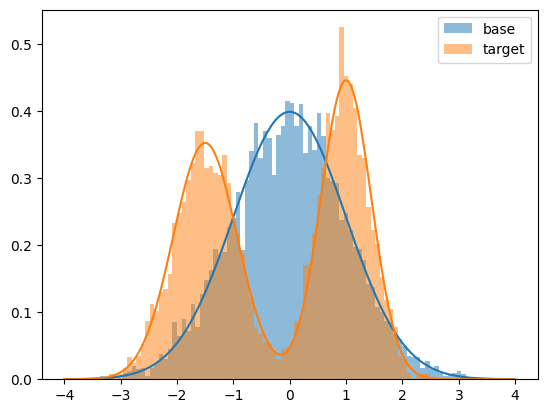

In [5]:
# Sample from the base and target distributions
num_samples = 5000
base_samples = base.sample(num_samples, seed=jax.random.PRNGKey(0))
target_samples = target.sample(num_samples, seed=jax.random.PRNGKey(1))

hist(base_samples, 100, range=[-4,4], label='base', color='C0', density=True,alpha=0.5);
plot(x, base.prob(x), color='C0');
hist(target_samples, 100, range=[-4,4], label='target', color='C1', density=True, alpha=0.5);
plot(x, target.prob(x), color='C1');
legend();

## Step II: Defining the control network and SDE

In [6]:
import flax.linen as nn

class ControlNN(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        # Encoding time
        freqs = (jnp.arange(3)+1)*np.pi
        t = freqs * jnp.atleast_1d(t)
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        x = jnp.concatenate([jnp.atleast_1d(x), t])
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=1)(x)
        return x.squeeze()

control = ControlNN()
params = control.init(jax.random.PRNGKey(0), jnp.zeros([1]), jnp.zeros([1]))

In [7]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

@jax.jit
@partial(jax.vmap, in_axes=(0, None))
def sample_process(key, params):
  t0, t1 = 0, 1
  drift = lambda t, y, args: control.apply(args[0], y, t)
  diffusion = lambda t, y, args: 1.
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.05, y0=0., args=(params,))
  return sol.ys[-1]

In [8]:
def g(x):
  return base.log_prob(x) - target.log_prob(x)

@jax.jit
def fn(x):
  return jax.vmap(jax.grad(g))(x)

def loss_fn(params, t, x_t, s):
  return jnp.mean((jax.vmap(control.apply, in_axes=(None, 0, 0))(params, x_t, t) + s)**2)

In [9]:
import optax

# Define the optimizer
optimizer = optax.adam(learning_rate=1e-3)

# Initialize the optimizer state
optimizer_state = optimizer.init(params)

# Define the training step
@jax.jit
def train_step(params, optimizer_state, t, x_t, s):
    loss, grads = jax.value_and_grad(loss_fn)(params, t, x_t, s)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

# Training loop
batch_size = 1024
key = jax.random.PRNGKey(0)

losses = []

Epoch 0, Loss: 2.6904053688049316
Epoch 10, Loss: 3.1078567504882812
Epoch 20, Loss: 2.937493324279785
Epoch 30, Loss: 2.7344226837158203
Epoch 40, Loss: 2.5642738342285156
Epoch 50, Loss: 2.6242692470550537
Epoch 60, Loss: 2.5927131175994873
Epoch 70, Loss: 2.908076763153076
Epoch 80, Loss: 2.8923845291137695
Epoch 90, Loss: 2.678539514541626
Epoch 100, Loss: 2.8323888778686523
Epoch 110, Loss: 3.0531301498413086
Epoch 120, Loss: 2.945570707321167
Epoch 130, Loss: 2.739039897918701
Epoch 140, Loss: 2.4196324348449707
Epoch 150, Loss: 2.9235477447509766
Epoch 160, Loss: 2.778153419494629
Epoch 170, Loss: 2.569835662841797
Epoch 180, Loss: 2.8935036659240723
Epoch 190, Loss: 2.5127525329589844
Epoch 200, Loss: 2.6634864807128906
Epoch 210, Loss: 2.6822547912597656
Epoch 220, Loss: 2.7838339805603027
Epoch 230, Loss: 2.6732864379882812
Epoch 240, Loss: 2.6609702110290527
Epoch 250, Loss: 3.066776990890503
Epoch 260, Loss: 2.8142764568328857
Epoch 270, Loss: 2.715027332305908
Epoch 280, L

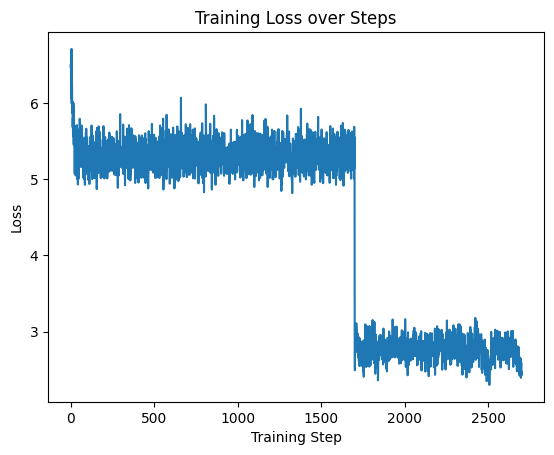

In [20]:
for epoch in range(1000):
  key, key_samples, key_t, key_x_t = jax.random.split(key, 4)

  # Sample a batch of points from the process
#   X_1 = jax.random.normal(key_samples, shape=(batch_size,))
  X_1 = sample_process(jax.random.split(key_samples,batch_size), params)

  t = jax.random.uniform(key_t, shape=(batch_size,))
  X_t = t * X_1 + jnp.sqrt(t*(1 - t)) * jax.random.normal(key_x_t, shape=(batch_size,))
  # Compute the score of the energy function
  scores = fn(X_1)

  params, optimizer_state, loss = train_step(params, optimizer_state, t, X_t, scores)
  losses.append(loss)

  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss}')

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

In [21]:
# Let's try to draw from the process now
samples = sample_process(jax.random.split(jax.random.PRNGKey(0),10000), params)

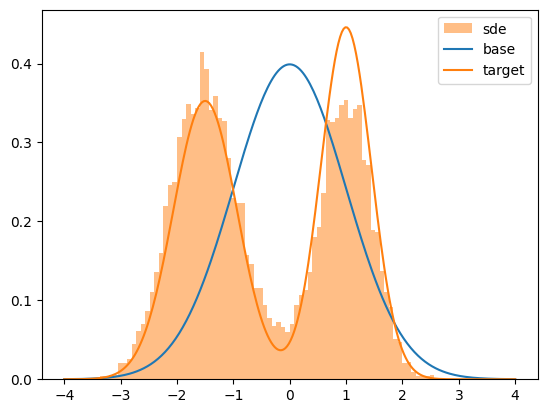

In [22]:
plt.hist(samples, 100, density=True, range=[-4,4], label='sde', alpha=0.5, color='C1');
plt.plot(x, base.prob(x), color='C0', label='base');
plt.plot(x, target.prob(x), color='C1', label='target');
plt.legend();

Let's take a look at the trajectories

In [ ]:
@jax.jit
@partial(jax.vmap, in_axes=(0, None))
def sample_trajectories(key, params):
  t0, t1 = 0, 1
  drift = lambda t, y, args: control.apply(args[0], y, t)
  diffusion = lambda t, y, args: 1.
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  solver = Euler()
  saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
  sol = diffeqsolve(terms, solver, t0, t1, dt0=0.005, y0=0., args=(params,), saveat=saveat)
  return sol.ts, sol.ys

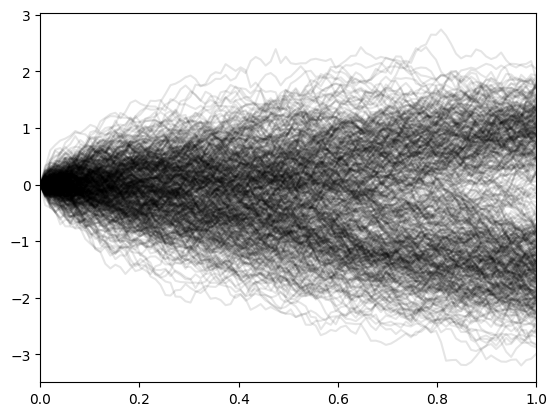

In [ ]:
t, trajectories = sample_trajectories(jax.random.split(jax.random.PRNGKey(0),512), params)
for i in range(512):
  plot(t[i], trajectories[i], alpha=0.1, color='k');
xlim(0,1.);